# Mini Project 3 - I. Word Embeddings

In [20]:
EMBEDDING_DIM = 50
CONTEXT_WINDOW = 4
NEGATIVE_SAMPLES = 2

UNKNOWN_TOKEN = "<ចម>"

In [21]:
from khmernltk import word_tokenize
from collections import Counter
import numpy as np
import tensorflow as tf

## Scratch: Read corpus and tokenizing

In [3]:
# Load and preprocess text
with open("temples.txt", "r", encoding="utf-8") as file:
    text = file.read()

In [4]:
unclean_tokens = word_tokenize(text)
print(f"number of tokens: {len(unclean_tokens)}")
token_counters = Counter(unclean_tokens)
print(f"Original vocab size: {len(token_counters)}")

| 2025-01-28 10:32:17,580 | INFO | khmer-nltk | Loaded model from /Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav |


number of tokens: 11521
Original vocab size: 2276


### Clean the tokens

In [5]:
import re

cleaned_vocabs = Counter()

zero_width_space = '\u200B' # zero width space from Internet
zero_width_space2 = '\u200C' # zero space from experiment below
ignores = [" ","-", "—", ":", "(", ")", "។", "[", "]", "ៗ", "៕", "៛", "៚", "៙", "៘", "៖", "\"",""]
ignores.append(zero_width_space)
ignores.append(zero_width_space2)

for token, count in token_counters.items():
    if token.strip() and token not in ignores and not re.match(r"^\[.*$", token) and not re.match(r".*\]$", token) and not re.match(r"^\(.*$", token) and not re.match(r".*\)$", token) and not re.match(r"^\d+$", token) and not token.isascii():
        cleaned_vocabs[token] = count

print(f"Clean vocabs: {len(cleaned_vocabs)}")

Clean vocabs: 2091


In [74]:
def get_unicode_code_points(token):
    """
    Get the Unicode code points of each character in the token.
    """
    return [ord(char) for char in token]

def format_code_points_as_hex(code_points):
    """
    Format the Unicode code points as hexadecimal strings.
    """
    return [f"U+{code_point:04X}" for code_point in code_points]

In [77]:
# with open("cleaned_vocabs.txt", "w", encoding="utf-8") as file:
#     row = []
#     for token, count in cleaned_vocabs.items():
        # code_points = get_unicode_code_points(token)
        # hex_code_points = format_code_points_as_hex(code_points)
        # row.append(f"{token} {count}")

    # file.write("\n".join(row))

In [6]:
cleaned_tokens = []
for token in unclean_tokens:
    if token in cleaned_vocabs:
        cleaned_tokens.append(token)

print(f"number of cleaned tokens: {len(cleaned_tokens)}")
print(f"Cleaned tokens: {cleaned_tokens[:10]}")

number of cleaned tokens: 9086
Cleaned tokens: ['ប្រាសាទ', 'អង្គរវត្ត', 'ឬ', 'ប្រាសាទ', 'អង្គរ', 'តូច', 'មាន', 'ទីតាំង', 'ស្ថិត', 'នៅ']


In [7]:
with open("cleaned_tokens.txt", "w", encoding="utf-8") as file:
    file.write(" ".join(cleaned_tokens))

In [9]:
vocabs_counter = Counter(cleaned_tokens)
print(f"vocab size: {len(vocabs_counter)}")

vocab size: 2091


## Alternative: Read Cleaned tokens

In [3]:
# Read cleaned tokens
with open("cleaned_tokens.txt", "r", encoding="utf-8") as file:
    cleaned_tokens = file.read().split()

In [4]:
print(f"number of cleaned tokens: {len(cleaned_tokens)}")
print(f"Cleaned tokens: {cleaned_tokens[:10]}")

number of cleaned tokens: 9086
Cleaned tokens: ['ប្រាសាទ', 'អង្គរវត្ត', 'ឬ', 'ប្រាសាទ', 'អង្គរ', 'តូច', 'មាន', 'ទីតាំង', 'ស្ថិត', 'នៅ']


In [5]:
vocabs_counter = Counter(cleaned_tokens)
print(f"vocab size: {len(vocabs_counter)}")

vocab size: 2091


In [6]:
print(vocabs_counter['ទីតាំង'])

7


## Skip-gram model
Given a Khmer text corpus “temples.txt” extracted from 3 Wikipedia pages1, build a skip-gram
model/classifier to find representation/embedding of each Khmer word in the corpus. Use the
following settings for your implementation:
- The word embedding has a dimension of 50
- For the skip-gram model, use context window $L$ = ±4 and negative sampling with $k$ = 2
- To tokenize word, you can use Khmer nltk2
- Your vocabulary should contain meaningful and frequent words so:
    - Words whose frequency is less than 10 are ignored
    - Spaces are considered a stop word and are also ignored

### Preparing dataset

In [7]:
FREQURNCY_THRESHOLD = 2
limited_vocabs = set()
for token, count in vocabs_counter.items():
    if count >= FREQURNCY_THRESHOLD:
        limited_vocabs.add(token)
    else:
        limited_vocabs.add(UNKNOWN_TOKEN)

limited_vocabs = list(limited_vocabs)
print(f"vocab size after limiting: {len(limited_vocabs)}")
limited_vocabs

vocab size after limiting: 940


['ស្តេច',
 'ប៉ុណ្ណោះ',
 'បាត់ដំបង',
 'បរម',
 'ការកសាង',
 'ផ្អែក',
 'ឃុំ',
 'ទាក់ទង',
 'នាម',
 'បន្ថែម',
 'ឥសូរ',
 'គ្រិស្ត',
 'ដ៏',
 'ចោរ',
 'កាន់តែ',
 'អំពី',
 'ស្មើ',
 'លយ',
 'ស្ថាបត្យកម្ម',
 'ទស្សនា',
 'ព្រះបាទ',
 'តាម',
 'ជាពិសេស',
 'ភ្នំពេញ',
 'ទីប្រជុំជន',
 'ចម្ងាយ',
 'ជាទូទៅ',
 'ខាងមុខ',
 'ក្រោម',
 'សាល',
 'ខាងជើង',
 'គ.',
 'ផ្ទុយ',
 'សករាជ',
 'គួរអោយ',
 'តាមរយៈ',
 'ថេរ',
 'គីឡូម៉ែត្រ',
 'ចូលទៅ',
 'អំឡុង',
 'ចំការដំនាំ',
 'ពួក',
 'នាំ',
 'សម័យកាល',
 'យកមក',
 'គ្រា',
 'ខ្លោងទ្វារ',
 'ភក់',
 'តិចតួច',
 'រយៈ',
 'រឺ',
 'និយម',
 'ធ្វើឡើង',
 'វិស័យ',
 'ផ្ទាំង',
 'បារាយ',
 'ពីរ',
 'តែ',
 'ពាយ័ព្យ',
 'និយាយ',
 'ក៏',
 'សាប',
 'ឬ',
 'ជនជាតិ',
 'កន្លះ',
 'ដំណាក់កាល',
 'សាច់រឿង',
 'រន្ទា',
 'កំពែង',
 'ទោះបី',
 'កំឡុង',
 'លាតសន្ធឹង',
 'ពេលវេលា',
 'នៃ',
 'រួមគ្នា',
 'ខាង',
 'ភ្លាម',
 'រំលឹក',
 'ទេ',
 'ឆក់',
 'ចម្បង',
 'លាន',
 'តំណាង',
 'បង្អស់',
 'ព័រទុយហ្គាល់',
 'មក',
 'រន្ធ',
 'ឲ្យ',
 'ជន់',
 'លើក',
 'រក',
 'ហើយនិង',
 '<ចម>',
 'បញ្ចប់',
 'ស្ដារ',
 'ឥត',
 'វចនានុក្រម',
 'ម្ដង',
 'ប្រយោជន៍',


In [8]:
vocab_size = len(limited_vocabs)
vocab_size

940

#### Word2Number

In [9]:
# Word to index and index to word
word_to_index = {word: i for i, word in enumerate(limited_vocabs)}
index_to_word = {i: word for word, i in word_to_index.items()}

In [10]:
print(len(word_to_index), word_to_index)
print(index_to_word)

940 {'ស្តេច': 0, 'ប៉ុណ្ណោះ': 1, 'បាត់ដំបង': 2, 'បរម': 3, 'ការកសាង': 4, 'ផ្អែក': 5, 'ឃុំ': 6, 'ទាក់ទង': 7, 'នាម': 8, 'បន្ថែម': 9, 'ឥសូរ': 10, 'គ្រិស្ត': 11, 'ដ៏': 12, 'ចោរ': 13, 'កាន់តែ': 14, 'អំពី': 15, 'ស្មើ': 16, 'លយ': 17, 'ស្ថាបត្យកម្ម': 18, 'ទស្សនា': 19, 'ព្រះបាទ': 20, 'តាម': 21, 'ជាពិសេស': 22, 'ភ្នំពេញ': 23, 'ទីប្រជុំជន': 24, 'ចម្ងាយ': 25, 'ជាទូទៅ': 26, 'ខាងមុខ': 27, 'ក្រោម': 28, 'សាល': 29, 'ខាងជើង': 30, 'គ.': 31, 'ផ្ទុយ': 32, 'សករាជ': 33, 'គួរអោយ': 34, 'តាមរយៈ': 35, 'ថេរ': 36, 'គីឡូម៉ែត្រ': 37, 'ចូលទៅ': 38, 'អំឡុង': 39, 'ចំការដំនាំ': 40, 'ពួក': 41, 'នាំ': 42, 'សម័យកាល': 43, 'យកមក': 44, 'គ្រា': 45, 'ខ្លោងទ្វារ': 46, 'ភក់': 47, 'តិចតួច': 48, 'រយៈ': 49, 'រឺ': 50, 'និយម': 51, 'ធ្វើឡើង': 52, 'វិស័យ': 53, 'ផ្ទាំង': 54, 'បារាយ': 55, 'ពីរ': 56, 'តែ': 57, 'ពាយ័ព្យ': 58, 'និយាយ': 59, 'ក៏': 60, 'សាប': 61, 'ឬ': 62, 'ជនជាតិ': 63, 'កន្លះ': 64, 'ដំណាក់កាល': 65, 'សាច់រឿង': 66, 'រន្ទា': 67, 'កំពែង': 68, 'ទោះបី': 69, 'កំឡុង': 70, 'លាតសន្ធឹង': 71, 'ពេលវេលា': 72, 'នៃ': 73, 'រួមគ្នា': 74, 'ខាង': 75, 

In [11]:
UNKNOWN_INDEX = word_to_index[UNKNOWN_TOKEN]
UNKNOWN_INDEX

92

In [12]:
limited_tokens = []
data = []
for token in cleaned_tokens:
    if token in word_to_index:
        limited_tokens.append(token)
        data.append(word_to_index[token])
    else:
        limited_tokens.append(UNKNOWN_TOKEN)
        data.append(word_to_index[UNKNOWN_TOKEN])

In [13]:
print(len(limited_tokens), limited_tokens)
print(len(data), data)

9086 ['ប្រាសាទ', 'អង្គរវត្ត', 'ឬ', 'ប្រាសាទ', 'អង្គរ', 'តូច', 'មាន', 'ទីតាំង', 'ស្ថិត', 'នៅ', 'ភាគ', 'ខាងជើង', 'នៃ', 'ក្រុង', 'សៀមរាប', 'នៃ', 'ខេត្ត', 'សៀមរាប', 'ប្រាសាទ', 'អង្គរវត្ត', 'ជា', 'ប្រាសាទ', 'ព្រហ្មញ្ញ', 'សាសនា', 'ធំ', 'បំផុត', 'និង', 'ជា', '<ចម>', 'សាសនា', 'ដ៏', 'ធំ', 'បំផុត', 'នៅក្នុង', 'លោក', 'ប្រាសាទ', 'នេះ', 'ត្រូវបាន', 'កសាងឡើង', 'ដោយ', 'ព្រះបាទ', 'សូរ្យ', 'វរ្ម័ន', 'ទី២', 'ដែល', 'ជា', 'ស្នាដៃ', 'ដ៏', 'ធំ', 'អស្ចារ្យ', 'និង', 'មាន', 'ឈ្មោះ', 'ល្បីល្បាញ', '<ចម>', '<ចម>', 'សាយ', 'ទៅ', 'គ្រប់', '<ចម>', 'លើ', 'ពិភពលោក', 'ប្រាសាទ', 'នេះ', 'សាងសង់', 'ឡើង', 'នៅ', 'ដើម', 'សតវត្ស', 'ទី', 'ដែល', 'ស្ថិត', 'នៅក្នុង', 'រាជធានី', 'សោធរ', 'បុរៈ', 'ប្រាសាទ', 'អង្គរវត្ត', 'ជា', 'ប្រាសាទ', 'កសាងឡើង', 'ដើម្បី', 'ឧទ្ទិស', 'ដល់', 'ព្រះវិស្ណុ', 'ប្រាសាទ', 'នេះ', 'ជា', 'ប្រាសាទ', 'ដែល', 'នៅ', '<ចម>', 'ល្អ', 'បំផុត', 'នៅក្នុង', 'តំបន់', 'អង្គរ', 'ប្រាសាទ', 'អង្គរវត្ត', 'ប្រើ', 'កម្លាំង', 'ពលកម្ម', 'ប្រម៉ាណ', 'ជាង', 'មុឺន', 'នាក់', 'និង', 'ដំរី', 'ជាង', 'ពាន់', 'ក្បាល', 'និង', 'ប្រើប្រាស់', 'ថ

In [14]:
np.save("word_to_index.npy", word_to_index)

In [15]:
def map_embbedings_to_word(embbedings, word_to_index):
    """
    Map the embeddings to the word.
    """
    word_to_embbedings = {}
    for word, index in word_to_index.items():
        word_to_embbedings[word] = embbedings[index]
    return word_to_embbedings

#### Create dataset

In [29]:
def generate_skipgram_data2(token_indices, window_size):
    """Generate skip-gram pairs."""
    skipgram_pairs = []
    for center_idx, center_word in enumerate(token_indices):
        context_range = range(max(center_idx - window_size, 0), 
                                min(center_idx + window_size + 1, len(token_indices)))
        for context_idx in context_range:
            if center_idx != context_idx:
                skipgram_pairs.append((center_word, token_indices[context_idx]))
    return skipgram_pairs

In [30]:
training_data = generate_skipgram_data2(data, CONTEXT_WINDOW)

In [31]:
print(f"Number of training data: {len(training_data)}")
print(f"Training data: {training_data[:10]}")

Number of training data: 72668
Training data: [(176, 564), (176, 62), (176, 176), (176, 535), (564, 176), (564, 62), (564, 176), (564, 535), (564, 678), (62, 176)]


### Skip-gram Model 1 - Simple Scratch

In [16]:
# Initialize word embeddings and context embeddings
word_embeddings = np.random.uniform(-1, 1, (vocab_size, EMBEDDING_DIM))
context_embeddings = np.random.uniform(-1, 1, (vocab_size, EMBEDDING_DIM))

In [17]:
def skipgram_model(center_word_index, context_word_index, label, learning_rate=0.01):
    # Forward pass
    center_embedding = word_embeddings[center_word_index]
    context_embedding = context_embeddings[context_word_index]
    prediction = np.dot(center_embedding, context_embedding)
    prediction = 1 / (1 + np.exp(-prediction))  # Sigmoid activation

    # Backward pass (simplified)
    error = label - prediction
    gradient_word = error * context_embedding
    gradient_context = error * center_embedding

    # Update embeddings (using a very basic gradient descent)
    word_embeddings[center_word_index] += learning_rate * gradient_word
    context_embeddings[context_word_index] += learning_rate * gradient_context
    return prediction

In [18]:
import random

def train(epochs, learning_rate):
    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for i, center_word in enumerate(limited_vocabs): # Iterate through all words as center words
            center_word_index = word_to_index[center_word]
            for j in range(max(0, i - CONTEXT_WINDOW), min(vocab_size, i + CONTEXT_WINDOW + 1)):
                if i != j: # Skip the center word itself
                    context_word = limited_vocabs[j]
                    context_word_index = word_to_index[context_word]
                    # Positive sample
                    loss = skipgram_model(center_word_index, context_word_index, 1, learning_rate)
                    total_loss += -np.log(loss) # Binary Cross-Entropy loss

                    # Negative samples
                    for _ in range(NEGATIVE_SAMPLES):
                        negative_word_index = random.randint(0, vocab_size - 1)
                        loss_neg = skipgram_model(center_word_index, negative_word_index, 0, learning_rate)
                        total_loss += -np.log(1-loss_neg) # Binary Cross-Entropy loss for negative samples

        print(f"Epoch: {epoch + 1}, Loss: {total_loss}")

In [19]:
EPOCHS = vocab_size  # Adjust as needed
LEARNING_RATE = 0.01  # Adjust as needed
train(EPOCHS, LEARNING_RATE)

Epoch: 1, Loss: 26399.89439049809
Epoch: 2, Loss: 25182.397935206787
Epoch: 3, Loss: 24343.308215037618
Epoch: 4, Loss: 23295.590095606243
Epoch: 5, Loss: 22314.73147178937
Epoch: 6, Loss: 21863.64268418254
Epoch: 7, Loss: 21061.61246136436
Epoch: 8, Loss: 20662.2418485731
Epoch: 9, Loss: 19726.44494227895
Epoch: 10, Loss: 19490.627275783714
Epoch: 11, Loss: 18821.996632332277
Epoch: 12, Loss: 18570.530979601317
Epoch: 13, Loss: 18308.255182897694
Epoch: 14, Loss: 18016.452464792703
Epoch: 15, Loss: 17734.83881596275
Epoch: 16, Loss: 17334.307412768558
Epoch: 17, Loss: 17231.50006900273
Epoch: 18, Loss: 17138.928951090857
Epoch: 19, Loss: 16787.838871344098
Epoch: 20, Loss: 16825.05480496314
Epoch: 21, Loss: 16507.650360050593
Epoch: 22, Loss: 16226.01107057664
Epoch: 23, Loss: 16079.850875668311
Epoch: 24, Loss: 15945.800840327058
Epoch: 25, Loss: 15837.42756732787
Epoch: 26, Loss: 15772.060111906967
Epoch: 27, Loss: 15616.93889250174
Epoch: 28, Loss: 15390.067318070587
Epoch: 29, Los

In [22]:
word_embeddings1 = {}
for w in limited_vocabs:
    w_index = word_to_index[w]
    word_embeddings1[w] = word_embeddings[w_index]

In [23]:
word_embeddings1

{'ស្តេច': array([-0.24335005,  0.08374731, -0.2523234 ,  0.76609961, -0.81963342,
        -0.33899395, -0.63230676,  0.21786055, -0.71088232,  0.56818984,
         0.05887588,  0.70738234, -0.88259691,  0.3957124 , -0.28021985,
        -0.29764021, -0.47812659,  0.66367729, -0.40103408, -0.49028107,
         1.01170542,  1.22677045, -0.48296407,  0.01834023,  0.04221612,
         0.47262012, -1.15566894, -0.09667246, -0.62003621,  1.25177699,
        -1.00337826, -0.0659129 ,  0.35965328, -0.21007902, -0.45249851,
         0.29226335,  0.80925415, -0.32067226, -0.8920254 ,  0.06581731,
         1.18576702, -0.05740663, -0.05478046, -1.97974147, -0.18121671,
         0.22586411, -0.64641296,  0.73320222, -1.19459961, -0.38143377]),
 'ប៉ុណ្ណោះ': array([-0.11039871,  0.67848296, -0.53389226,  1.72374887, -0.10225312,
        -0.45671449, -0.43581486, -0.66693777, -0.98285584, -0.04478912,
         0.11258833,  1.00677477, -0.9194329 ,  0.30139267, -0.91714249,
         0.26774265, -0.7231

In [24]:
np.save("word_to_embedding1.npy", word_embeddings1)

#### Plot

/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 91 ([) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


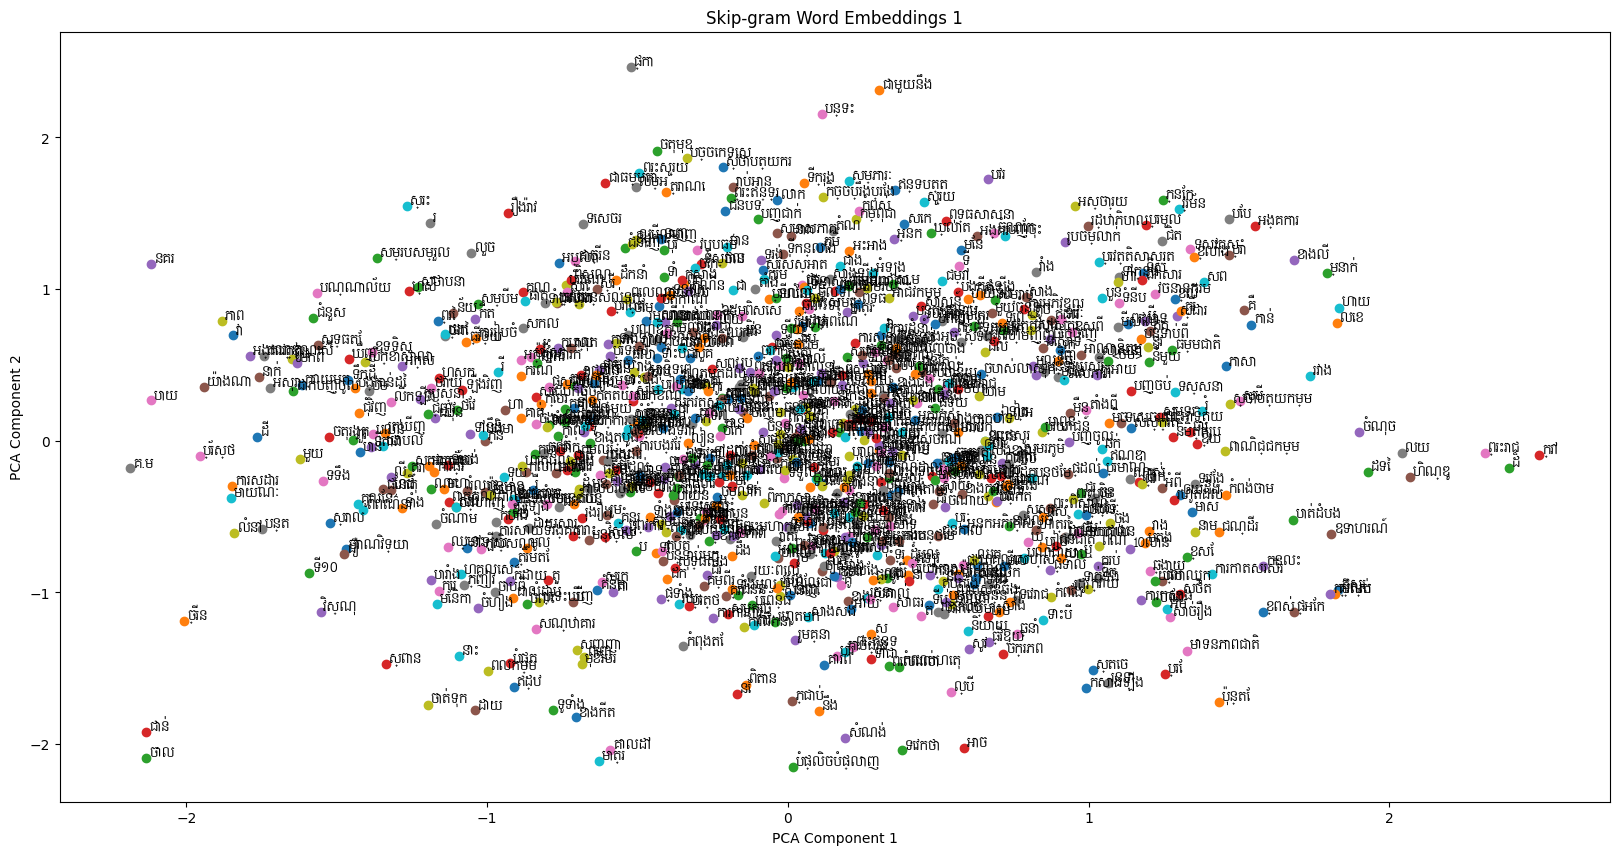

{'ស្តេច': array([ 1.01549465, -1.511293  ]),
 'ប៉ុណ្ណោះ': array([ 0.56534215, -0.8802908 ]),
 'បាត់ដំបង': array([ 1.67919645, -0.5221241 ]),
 'បរម': array([ 0.66471617, -1.15410969]),
 'ការកសាង': array([ 1.17419038, -1.05188205]),
 'ផ្អែក': array([ 1.68202086, -1.12961205]),
 'ឃុំ': array([ 0.79909499, -0.66778294]),
 'ទាក់ទង': array([ 0.97205522, -0.9345896 ]),
 'នាម': array([ 1.35416415, -0.59824195]),
 'បន្ថែម': array([ 0.81028143, -0.24266482]),
 'ឥសូរ': array([ 1.83050803, -0.9859065 ]),
 'គ្រិស្ត': array([ 1.82051822, -1.01015932]),
 'ដ៏': array([ 2.39712404, -0.17724697]),
 'ចោរ': array([1.33661278, 0.06045526]),
 'កាន់តែ': array([ 0.71069833, -0.14387865]),
 'អំពី': array([ 1.24485623, -0.31179363]),
 'ស្មើ': array([1.50397035, 0.25986958]),
 'លយ': array([ 2.04218546, -0.07737221]),
 'ស្ថាបត្យកម្ម': array([1.47089459, 0.2411511 ]),
 'ទស្សនា': array([1.28590584, 0.32456336]),
 'ព្រះបាទ': array([1.13100427, 0.77255703]),
 'តាម': array([ 0.52333768, -0.21102397]),
 'ជាពិសេស': arra

In [25]:
import pca_utils

pca_utils.reduce_and_plot_data(word_embeddings1, word_to_index, index_to_word, "Skip-gram Word Embeddings 1")

### Skip-Gram Model 2 - Simple using tensorflow

In [26]:
def generate_batch(training_data, vocab_size, batch_size=128, negative_samples=2):
    total_positive_samples = 0
    total_negative_samples = 0
    while True:
        x, y = [], []
        for _ in range(batch_size):
            target_word, context_word = training_data[
                np.random.randint(0, len(training_data))
            ]
            x.append(target_word)
            y.append(context_word)
            total_positive_samples += 1
            for _ in range(negative_samples):
                negative_word = np.random.randint(0, vocab_size)
                x.append(target_word)
                y.append(negative_word)
                total_negative_samples += 1
        # print(f"Total positive samples: {total_positive_samples}")
        # print(f"Total negative samples: {total_negative_samples}")
        yield np.array(x), np.array(y)

In [27]:
BATCH_SIZE = 128

In [32]:
next(generate_batch(training_data, vocab_size, BATCH_SIZE, NEGATIVE_SAMPLES))

(array([812, 812, 812,  92,  92,  92, 168, 168, 168,  73,  73,  73, 535,
        535, 535, 312, 312, 312,  73,  73,  73, 239, 239, 239, 191, 191,
        191, 121, 121, 121, 495, 495, 495,  44,  44,  44, 185, 185, 185,
        283, 283, 283, 186, 186, 186, 317, 317, 317, 196, 196, 196, 180,
        180, 180, 504, 504, 504, 174, 174, 174, 860, 860, 860, 473, 473,
        473, 827, 827, 827, 362, 362, 362, 827, 827, 827, 514, 514, 514,
        668, 668, 668, 665, 665, 665, 830, 830, 830, 913, 913, 913, 690,
        690, 690, 104, 104, 104,  92,  92,  92, 500, 500, 500,  92,  92,
         92, 114, 114, 114,  51,  51,  51, 469, 469, 469,  72,  72,  72,
        373, 373, 373, 400, 400, 400,  92,  92,  92, 771, 771, 771, 484,
        484, 484, 900, 900, 900, 635, 635, 635, 354, 354, 354,  92,  92,
         92, 173, 173, 173,  92,  92,  92, 629, 629, 629, 484, 484, 484,
        224, 224, 224,  92,  92,  92, 811, 811, 811,  92,  92,  92, 294,
        294, 294,   8,   8,   8,  92,  92,  92, 473

In [33]:
steps_per_epoch = len(training_data) // BATCH_SIZE
steps_per_epoch

567

In [37]:
sg_model2 = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, input_length=1),
        tf.keras.layers.Dense(vocab_size, activation="softmax"),
    ]
)
sg_model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
sg_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1, 50)             47000     
                                                                 
 dense_2 (Dense)             (None, 1, 940)            47940     
                                                                 
Total params: 94940 (370.86 KB)
Trainable params: 94940 (370.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
sg_model2.fit(
    generate_batch(training_data, len(limited_vocabs), BATCH_SIZE, NEGATIVE_SAMPLES),
    steps_per_epoch=steps_per_epoch,
    epochs=30
)

Epoch 1/30
567/567 [==============================] - 3s 5ms/step - loss: 6.7295
Epoch 2/30
567/567 [==============================] - 3s 4ms/step - loss: 6.6175
Epoch 3/30
567/567 [==============================] - 3s 5ms/step - loss: 6.6057
Epoch 4/30
567/567 [==============================] - 3s 5ms/step - loss: 6.6013
Epoch 5/30
567/567 [==============================] - 3s 5ms/step - loss: 6.5922
Epoch 6/30
567/567 [==============================] - 3s 5ms/step - loss: 6.5846
Epoch 7/30
567/567 [==============================] - 3s 5ms/step - loss: 6.5754
Epoch 8/30
567/567 [==============================] - 3s 5ms/step - loss: 6.5678
Epoch 9/30
567/567 [==============================] - 3s 5ms/step - loss: 6.5599
Epoch 10/30
567/567 [==============================] - 3s 5ms/step - loss: 6.5564
Epoch 11/30
567/567 [==============================] - 3s 5ms/step - loss: 6.5480
Epoch 12/30
567/567 [==============================] - 3s 5ms/step - loss: 6.5416
Epoch 13/30
567/567 [====

In [39]:
# Extract the word embeddings
embeddings2 = sg_model2.layers[0].get_weights()[0]
embeddings2

array([[-0.38899854,  0.5195456 ,  0.24717951, ...,  0.25955275,
        -0.20594905,  0.3362302 ],
       [-0.55120236,  0.19914359,  0.1490227 , ...,  0.10242474,
         0.09578814,  0.25183555],
       [ 0.18901771,  0.24065286, -0.01146635, ...,  0.39945862,
         0.08770315,  0.16590671],
       ...,
       [-0.5192715 , -0.55623853,  0.04017681, ...,  0.21095715,
         0.24691735, -0.32132003],
       [ 0.12373596,  0.07861336,  0.7014848 , ...,  0.2258057 ,
         0.06812153,  0.5088363 ],
       [-0.3964683 ,  0.17060432, -0.13384044, ..., -0.28643674,
         0.34592298, -0.06071275]], dtype=float32)

In [40]:
# Loop through the embeddings and map to words
word_to_embedding2 = map_embbedings_to_word(embeddings2, word_to_index)

In [41]:
word_to_embedding2[UNKNOWN_TOKEN]

array([-0.1932597 ,  0.11679985,  0.20123753, -0.03930499,  0.08965743,
       -0.12152082, -0.00668663, -0.01977204, -0.10305721,  0.06914396,
        0.15443736, -0.04639972, -0.16018733, -0.07425057, -0.19185628,
        0.11136104,  0.0773767 , -0.01262984,  0.23694284,  0.02468207,
       -0.10917849, -0.10510024, -0.09633604,  0.01669127,  0.07149891,
       -0.10688823,  0.07473198,  0.1551833 , -0.06274672,  0.08164976,
        0.09049528, -0.12910329,  0.09719425,  0.09492049, -0.06864195,
        0.01013962,  0.10114314,  0.08684208,  0.1014231 , -0.2715575 ,
        0.06043505, -0.22986446, -0.10830906, -0.20266633, -0.2584648 ,
       -0.04492793, -0.11555684,  0.11127066, -0.0651064 , -0.07727178],
      dtype=float32)

In [42]:
np.save("word_to_embedding2.npy", word_to_embedding2)

/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 91 ([) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


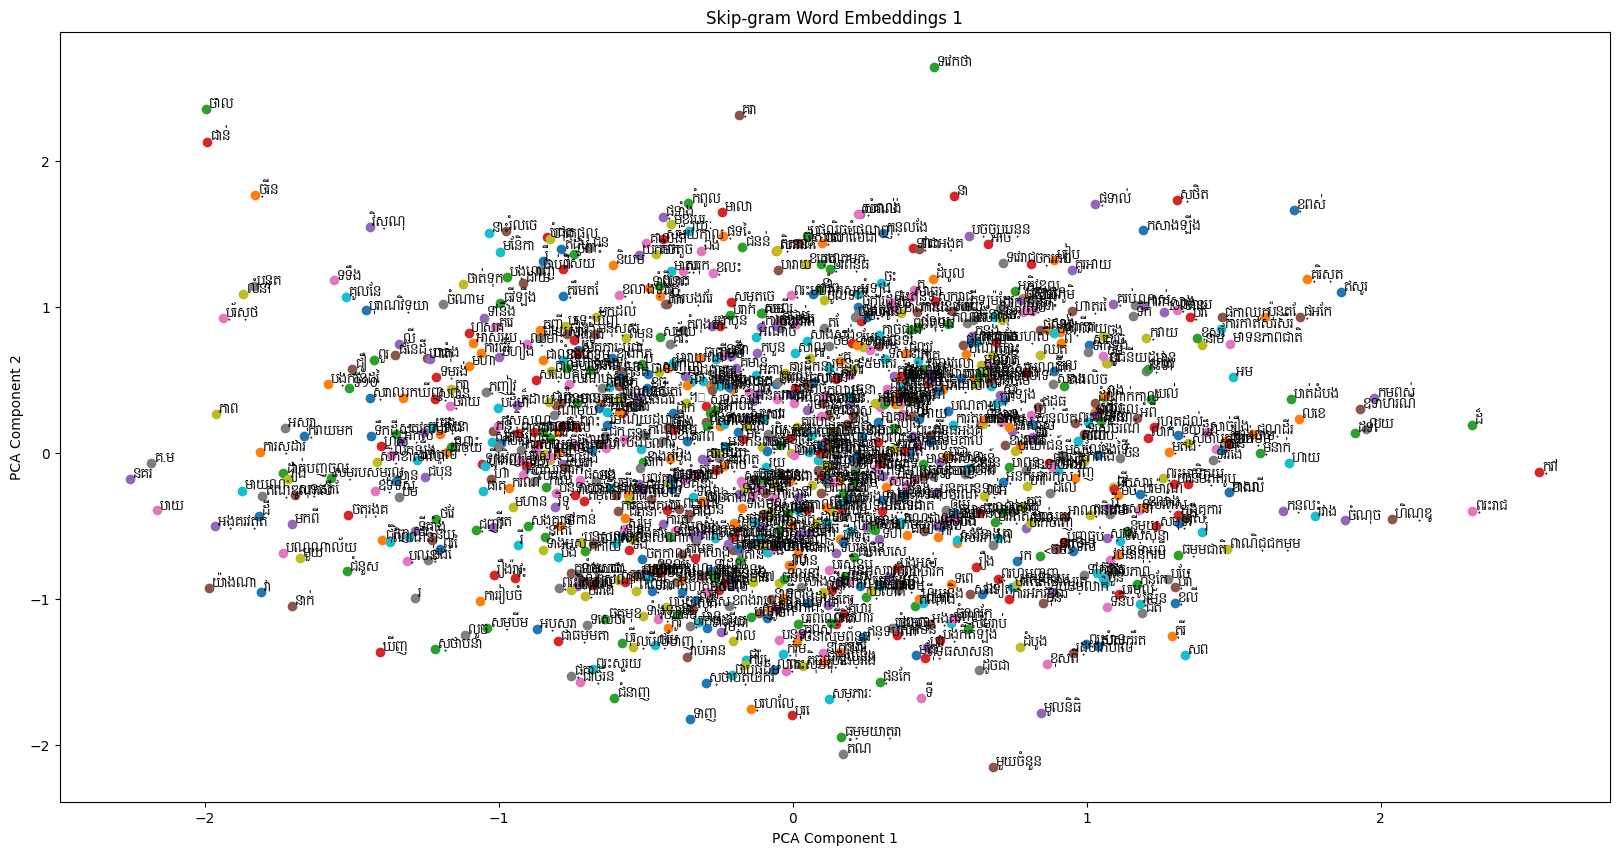

In [61]:
import pca_utils

reduced_embeddings = pca_utils.reduce_and_plot_data(word_embeddings1, word_to_index, index_to_word, "Skip-gram Word Embeddings 1")

In [64]:
print(reduced_embeddings)

{'ស្តេច': array([1.00921339, 0.73978793]), 'ប៉ុណ្ណោះ': array([0.58992048, 0.67871586]), 'បាត់ដំបង': array([1.69410818, 0.36901275]), 'បរម': array([0.69094144, 0.76427219]), 'ការកសាង': array([1.19341235, 1.00591761]), 'ផ្អែក': array([1.72554806, 0.9316312 ]), 'ឃុំ': array([0.80950549, 0.26134395]), 'ទាក់ទង': array([1.00571909, 0.69423459]), 'នាម': array([1.3929547 , 0.74410751]), 'បន្ថែម': array([0.67487973, 0.4594396 ]), 'ឥសូរ': array([1.86459665, 1.10312339]), 'គ្រិស្ត': array([1.74970828, 1.19011671]), 'ដ៏': array([2.31166978, 0.19543944]), 'ចោរ': array([ 1.29613273, -0.21040644]), 'កាន់តែ': array([0.64039781, 0.19655215]), 'អំពី': array([1.17076425, 0.2414908 ]), 'ស្មើ': array([1.43953599, 0.03185201]), 'លយ': array([1.94986544, 0.16431017]), 'ស្ថាបត្យកម្ម': array([1.3458335 , 0.06646986]), 'ទស្សនា': array([ 1.11463472, -0.59933981]), 'ព្រះបាទ': array([ 0.99659534, -1.3092695 ]), 'តាម': array([0.34669312, 0.33994444]), 'ជាពិសេស': array([ 0.20941105, -0.71206532]), 'ភ្នំពេញ': array([-

In [65]:
print(reduced_embeddings['ខាងត្បូង'])

[-0.5084879  -0.06148669]


In [71]:
word = "ខាងលិច"
word1_embedding = reduced_embeddings[word]
similarities = {}
for w, embedding in reduced_embeddings.items():
    score = np.dot(word1_embedding, embedding) / (np.linalg.norm(word1_embedding) * np.linalg.norm(embedding))
    similarities[w] = score

sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
sorted_similarities[:10]

[('ខាងលិច', 1.0),
 ('បុរៈ', 0.9999998870791484),
 ('មោទនភាពជាតិ', 0.9999964815547078),
 ('ខាងជើង', 0.999992273601527),
 ('របៀង', 0.999989921638458),
 ('កំឡុង', 0.9999675346982583),
 ('ហែង', 0.9998295491481461),
 ('រន្ទា', 0.999661327984973),
 ('សសរ', 0.9996600552051192),
 ('នាម', 0.9996334578203148)]

In [68]:
import pca_utils
pca_utils.similarity("ស្ថិត", reduced_embeddings)

AttributeError: module 'pca_utils' has no attribute 'similarity'

### Skip Game Model 3 - Custom class using tensorflow

In [44]:
import random

def get_negative_samples(vocab_size, positive_samples, num_negative):
    """Generate negative samples."""
    negatives = []
    for _ in range(len(positive_samples)):
        negative_samples = random.choices(range(vocab_size), k=num_negative)
        negatives.append(negative_samples)
    return negatives

In [45]:
class SkipGramModel3(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel3, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=1, name="target_embedding")
        self.context_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=1, name="context_embedding")

    def call(self, inputs):
        target, context, negative_samples = inputs
        target_embed = self.target_embedding(target)
        context_embed = self.context_embedding(context)
        negative_embed = self.context_embedding(negative_samples)

        pos_similarity = tf.reduce_sum(target_embed * context_embed, axis=-1)
        neg_similarity = tf.reduce_sum(target_embed[:, None, :] * negative_embed, axis=-1)

        pos_loss = -tf.math.log(tf.keras.activations.sigmoid(pos_similarity))
        neg_loss = -tf.reduce_sum(tf.math.log(tf.keras.activations.sigmoid(-neg_similarity)), axis=-1)

        return tf.reduce_mean(pos_loss + neg_loss)


In [46]:
def train_skipgram_model3(model, skipgram_pairs, vocab_size, neg_samples=2, epochs=20, batch_size=256, learning_rate=0.01):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    targets, contexts = zip(*skipgram_pairs)

    # Generate negative samples
    negative_samples = get_negative_samples(vocab_size, skipgram_pairs, neg_samples)

    # Convert lists to NumPy arrays
    targets = np.array(targets, dtype=np.int32)
    contexts = np.array(contexts, dtype=np.int32)
    negative_samples = np.array(negative_samples, dtype=np.int32)

    # Ensure `negative_samples` has the shape (num_pairs, k) for proper batching
    negative_samples = np.reshape(negative_samples, (len(targets), -1))

    # Prepare the dataset
    dataset = tf.data.Dataset.from_tensor_slices((targets, contexts, negative_samples))
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True)

    total_step = len(dataset)//batch_size

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        step = 0
        for batch in dataset:
            target_batch, context_batch, negative_batch = batch

            with tf.GradientTape() as tape:
                loss = model([target_batch, context_batch, negative_batch])

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            total_loss += loss.numpy()
            print(f"Epoch: {epoch + 1}/{epochs}, Step: {step+1}/{total_step}, Loss: {total_loss}")
            step += 1

    return optimizer

In [47]:
BATCH_SIZE = 128

In [48]:
model3 = SkipGramModel3(vocab_size, EMBEDDING_DIM)

In [49]:
optimizer = train_skipgram_model3(model3, training_data, vocab_size, learning_rate=0.01, epochs=30, neg_samples=NEGATIVE_SAMPLES, batch_size=BATCH_SIZE)

In [50]:
embedding_layer = model3.get_layer("target_embedding")
embeddings3 = embedding_layer.get_weights()[0]
embeddings3

array([[-0.7884181 ,  1.0191346 , -1.0517513 , ..., -3.304753  ,
        -0.7581538 , -0.33113745],
       [ 1.4119122 , -0.0914674 ,  0.13252228, ..., -0.9692329 ,
         0.16951507, -0.5165972 ],
       [ 1.6041504 ,  0.5817452 , -1.5777274 , ...,  1.7195514 ,
        -0.77616936, -3.5373151 ],
       ...,
       [ 0.36700037,  0.18196926,  0.38207743, ..., -0.16158785,
         0.5974768 ,  0.62083423],
       [-0.00475634,  0.8492683 ,  1.0502874 , ..., -0.6225438 ,
        -4.2681785 , -0.5273631 ],
       [ 0.8316998 , -0.38164046,  0.13082361, ...,  0.07047669,
        -0.22408138, -0.27104715]], dtype=float32)

In [51]:
word_to_embedding3 = map_embbedings_to_word(embeddings3, word_to_index)
word_to_embedding3

{'ស្តេច': array([-0.7884181 ,  1.0191346 , -1.0517513 , -1.5882152 ,  0.11450683,
         2.0076334 , -0.5209428 , -0.2630243 ,  1.1175947 ,  2.2421849 ,
         0.21249875, -5.0180254 ,  0.23989311, -0.08002346,  2.1003623 ,
         3.1918707 , -1.7556666 , -0.05813958,  0.05561526, -0.9491152 ,
        -1.4655353 , -0.30935764, -0.16706842,  1.4224118 , -1.1831226 ,
        -0.15210122, -2.3185844 , -0.45663273, -2.057748  ,  0.7026339 ,
        -0.7212043 , -0.19840802,  1.6376189 ,  0.03603327,  2.9334733 ,
        -1.1247681 , -0.9383895 , -1.86081   ,  0.6137163 , -2.7233312 ,
         0.3379462 , -0.07806768,  2.3931148 ,  0.41569337,  1.2853644 ,
        -4.243571  , -2.346024  , -3.304753  , -0.7581538 , -0.33113745],
       dtype=float32),
 'ប៉ុណ្ណោះ': array([ 1.4119122 , -0.0914674 ,  0.13252228, -0.77705246, -0.24044123,
        -0.3164454 ,  0.02354021,  0.9870738 ,  0.0338388 ,  0.71591157,
         0.7591204 , -1.2240423 , -0.03401844,  0.46545836,  1.0421351 ,
      

In [52]:
np.save("word_to_embedding3.npy", word_to_embedding3)

/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 91 ([) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


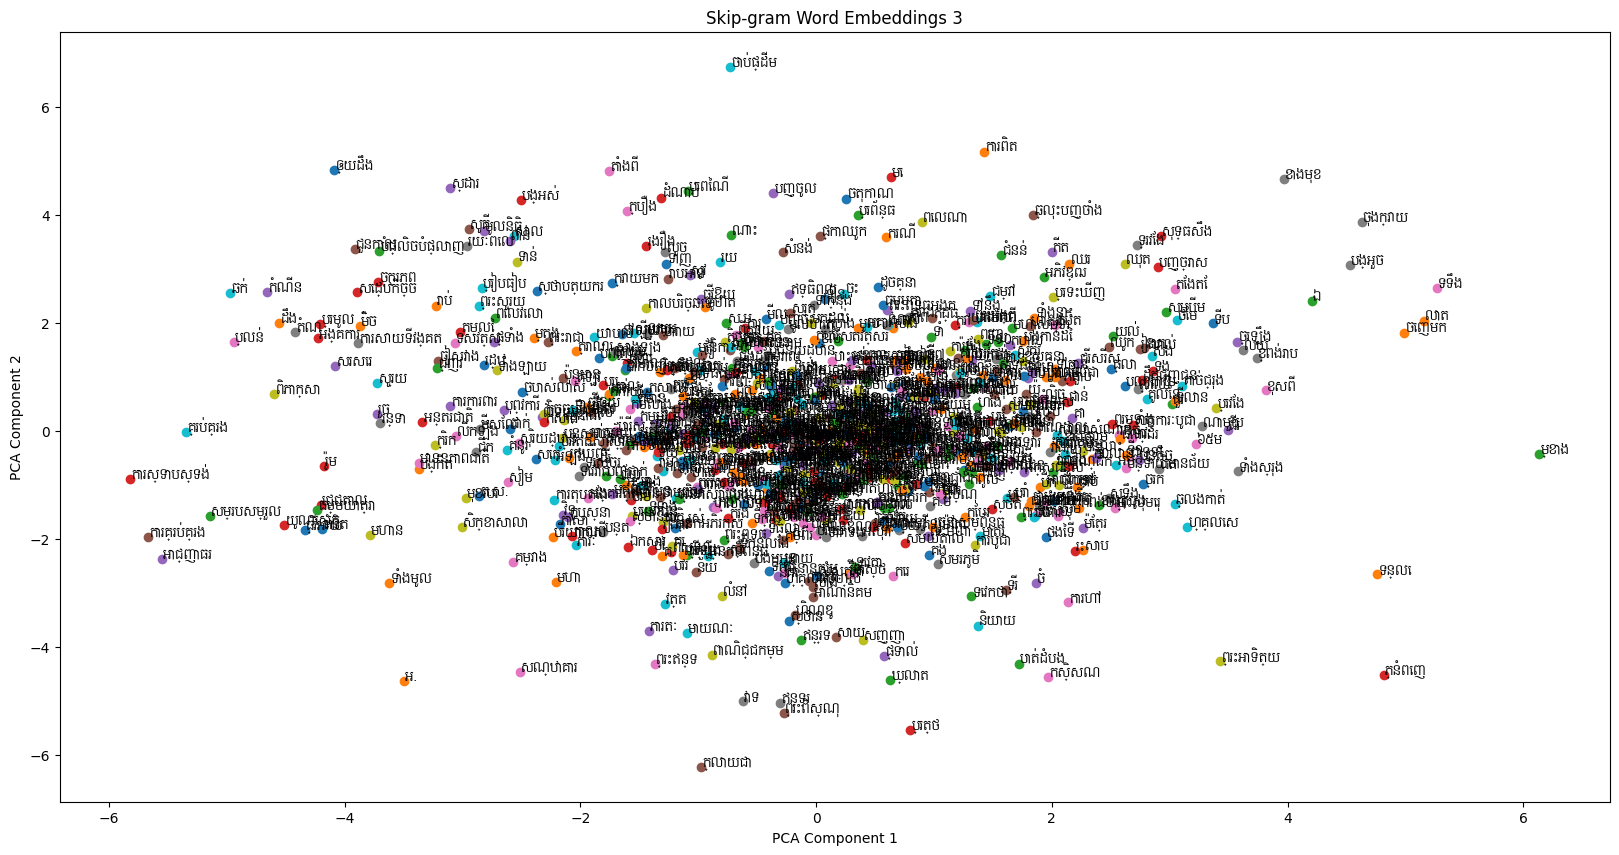

{'ស្តេច': array([-0.67933972,  0.08197164]),
 'ប៉ុណ្ណោះ': array([-0.17671829, -0.51355977]),
 'បាត់ដំបង': array([ 1.72070534, -4.3183661 ]),
 'បរម': array([-1.57112696, -1.28893278]),
 'ការកសាង': array([-0.1858044 , -0.46546906]),
 'ផ្អែក': array([ 0.95350171, -1.13952519]),
 'ឃុំ': array([ 2.05548964, -1.57379431]),
 'ទាក់ទង': array([ 0.08506817, -1.97409626]),
 'នាម': array([ 0.65953914, -0.19897243]),
 'បន្ថែម': array([-0.9791277 ,  0.06826459]),
 'ឥសូរ': array([-0.10773095, -0.47284187]),
 'គ្រិស្ត': array([-0.47465907,  0.98382492]),
 'ដ៏': array([ 0.25989822, -0.69668712]),
 'ចោរ': array([ 0.24919433, -1.04133858]),
 'កាន់តែ': array([0.83696443, 0.36861639]),
 'អំពី': array([0.65951477, 1.22454349]),
 'ស្មើ': array([ 2.06167562, -1.52580627]),
 'លយ': array([3.61843967, 1.50541223]),
 'ស្ថាបត្យកម្ម': array([0.3566904 , 0.78588643]),
 'ទស្សនា': array([-0.12361255,  0.49872657]),
 'ព្រះបាទ': array([-0.28912151, -0.10417724]),
 'តាម': array([ 0.63259587, -0.49656269]),
 'ជាពិសេស': ar

In [53]:
import pca_utils

pca_utils.reduce_and_plot_data(word_to_embedding3, word_to_index, index_to_word, "Skip-gram Word Embeddings 3")

### Skip-Gram Model 4

In [72]:
import numpy as np

def skipgram(tokenized, vocab_size, window_size=4, negative_samples=2):
    """
    Generate skip-gram pairs with positive and negative examples manually.

    Args:
    - tokenized: List of word indices (tokenized corpus).
    - vocab_size: Size of the vocabulary.
    - window_size: Size of the context window (± window_size).
    - negative_samples: Number of negative samples to generate per positive pair.

    Returns:
    - targets: Target words (center words).
    - contexts: Context words (positive and negative examples).
    - labels: Labels for training (1 for positive pairs, 0 for negative pairs).
    """
    targets, contexts, labels = [], [], []

    for i, target in enumerate(tokenized):
        # Define context window boundaries
        start = max(i - window_size, 0)
        end = min(i + window_size + 1, len(tokenized))

        # Positive examples: Words within the context window
        positive_context = [tokenized[j] for j in range(start, end) if j != i]
        for context in positive_context:
            targets.append(target)
            contexts.append(context)
            labels.append(1)  # Positive pair

        # Negative sampling: Randomly sample words outside the context
        negative_context = np.random.choice(
            vocab_size, 
            size=negative_samples, 
            replace=False
        )
        for neg_context in negative_context:
            targets.append(target)
            contexts.append(neg_context)
            labels.append(0)  # Negative pair

    return np.array(targets), np.array(contexts), np.array(labels)

In [73]:
# Generate Skip-gram Data
targets, contexts, labels = skipgram(data, len(limited_vocabs), window_size=CONTEXT_WINDOW, negative_samples=NEGATIVE_SAMPLES)

In [74]:
targets.shape, contexts.shape, labels.shape

((90840,), (90840,), (90840,))

In [75]:
def build_skipgram_model(vocab_size, embedding_dim):
    """Build a skip-gram model using negative sampling."""
    # Inputs for target and context words
    target_input = tf.keras.Input(shape=(1,), name="target_input")
    context_input = tf.keras.Input(shape=(1,), name="context_input")
    
    # Embedding layers for target and context
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim, 
        input_length=1, 
        name="embedding"
    )
    
    target_embedding = embedding_layer(target_input)
    context_embedding = embedding_layer(context_input)
    
    # Compute dot product
    dot_product = tf.reduce_sum(target_embedding * context_embedding, axis=-1)
    output = tf.keras.layers.Activation("sigmoid")(dot_product)
    
    # Build and compile model
    model = tf.keras.Model(inputs=[target_input, context_input], outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy")
    return model

In [76]:
model = build_skipgram_model(len(limited_vocabs), EMBEDDING_DIM)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 target_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 context_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                47000     ['target_input[0][0]',        
                                                                     'context_input[0][0]']       
                                                                                                  
 tf.math.multiply (TFOpLamb  (None, 1, 50)                0         ['embedding[0][0]',       

In [77]:
epochs = 20
batch_size = 32
# Train the Model
history = model.fit(
    [targets, contexts],
    labels,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
2839/2839 [==============================] - 4s 1ms/step - loss: 0.4765
Epoch 2/20
2839/2839 [==============================] - 3s 1ms/step - loss: 0.4303
Epoch 3/20
2839/2839 [==============================] - 3s 1ms/step - loss: 0.4159
Epoch 4/20
2839/2839 [==============================] - 5s 2ms/step - loss: 0.3908
Epoch 5/20
2839/2839 [==============================] - 4s 2ms/step - loss: 0.3595
Epoch 6/20
2839/2839 [==============================] - 5s 2ms/step - loss: 0.3289
Epoch 7/20
2839/2839 [==============================] - 4s 1ms/step - loss: 0.3017
Epoch 8/20
2839/2839 [==============================] - 5s 2ms/step - loss: 0.2783
Epoch 9/20
2839/2839 [==============================] - 4s 1ms/step - loss: 0.2583
Epoch 10/20
2839/2839 [==============================] - 5s 2ms/step - loss: 0.2415
Epoch 11/20
2839/2839 [==============================] - 4s 2ms/step - loss: 0.2270
Epoch 12/20
2839/2839 [==============================] - 4s 1ms/step - loss: 0.2147
E

In [82]:
# Extract Embeddings
embeddings4 = model.get_layer("embedding").get_weights()[0]
embeddings4

array([[ 0.26194903, -0.06821271, -0.50549734, ..., -0.3831329 ,
        -0.44995755, -0.53038394],
       [-0.47073463, -0.0575791 , -0.4254694 , ...,  1.253528  ,
        -1.249604  , -1.0740535 ],
       [-0.10550959, -0.89546704, -1.6514044 , ...,  0.15416418,
        -1.0912838 ,  1.6588044 ],
       ...,
       [ 0.38184482, -0.29477003, -0.617668  , ..., -1.2399164 ,
        -0.38998097,  0.59382105],
       [ 0.47651866,  0.02178224, -0.14632164, ...,  0.4152954 ,
         1.0398332 , -0.55384064],
       [ 1.1896302 ,  0.50457996,  0.17416118, ...,  2.1015744 ,
         0.18568249,  0.20747189]], dtype=float32)

In [83]:
# Loop through the embeddings and map to words
word_to_embedding4 = map_embbedings_to_word(embeddings4, word_to_index)

In [84]:
word_to_embedding4

{'ស្តេច': array([ 0.26194903, -0.06821271, -0.50549734, -0.11983121, -0.73293793,
        -0.17747998,  0.4479702 , -0.56315845,  0.66216004,  0.02224791,
        -0.81473976,  0.35467127,  0.09048914, -0.24063633, -0.6415359 ,
         0.38442472, -0.2288991 , -0.13454282,  0.58221835, -0.27380064,
        -0.13965347, -0.90430015,  0.0732943 , -0.32009965, -0.18742613,
         0.18756878, -0.12150337,  0.0464035 ,  0.7802418 , -0.17068888,
         0.16102235,  0.88347816,  0.11077262, -0.3209318 ,  1.0088781 ,
        -0.50442564,  0.60862   , -1.2550384 ,  0.37765777,  0.79404485,
        -0.01635113, -0.76263285,  1.1059151 , -0.03611085, -0.10566173,
        -0.38223708,  0.24972332, -0.3831329 , -0.44995755, -0.53038394],
       dtype=float32),
 'ប៉ុណ្ណោះ': array([-0.47073463, -0.0575791 , -0.4254694 , -1.0732499 ,  0.32082304,
         0.0823384 , -0.5245503 ,  1.610312  , -0.7788628 , -0.21010439,
         0.3472018 ,  0.4475434 , -0.6446387 ,  0.45293114,  0.32189924,
      

In [81]:
np.save("word_to_embedding4.npy", word_to_embedding4)

/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maohieng/master-degree/learn_ai/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 91 ([) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


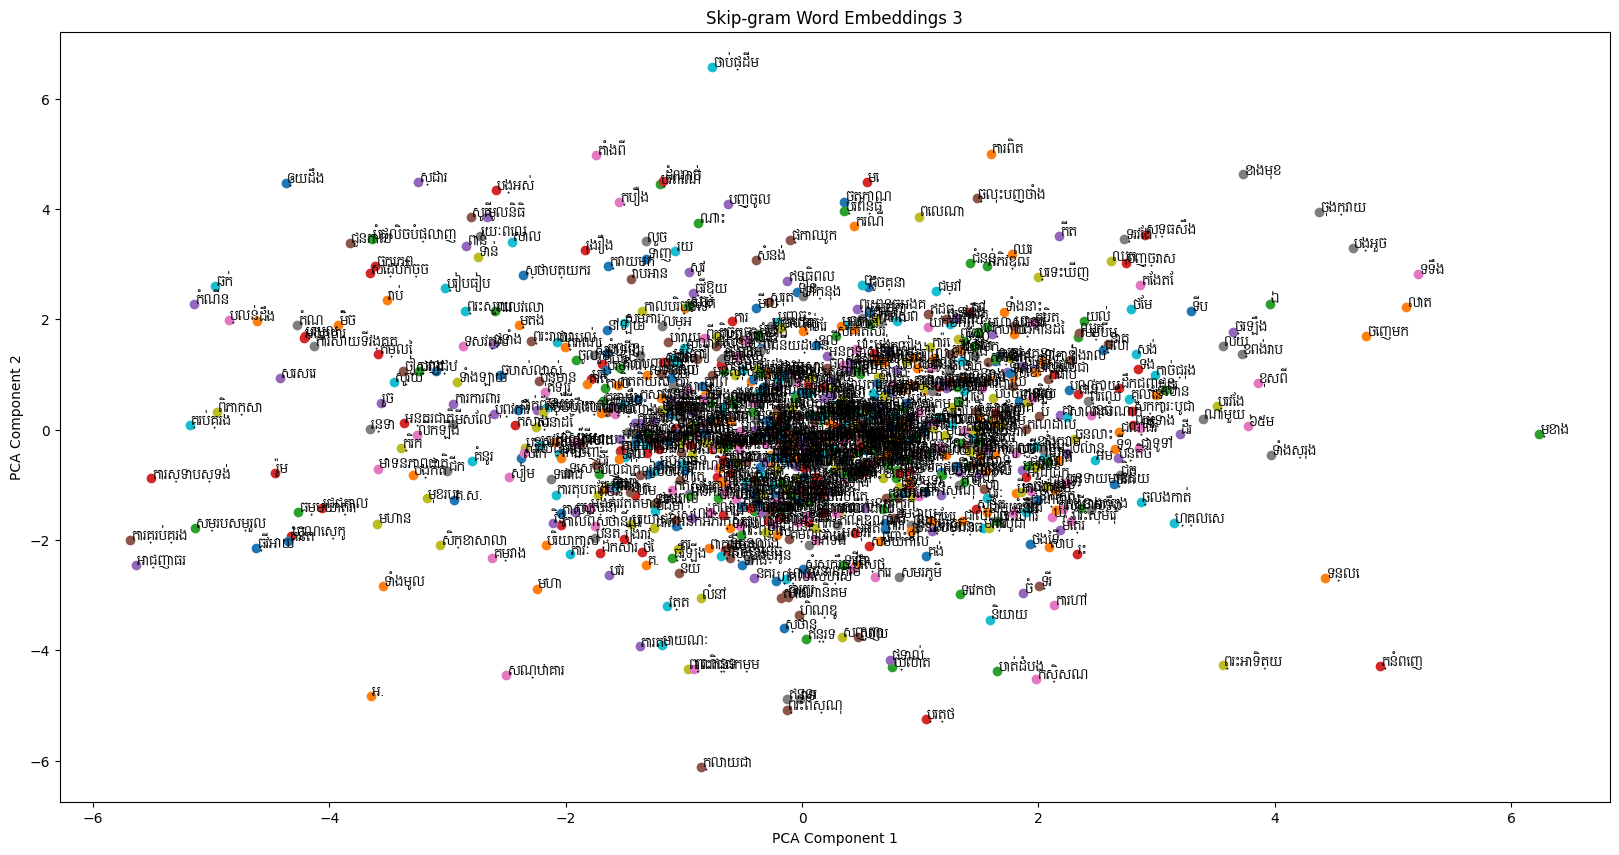

In [85]:
import pca_utils

reduced_embeddings = pca_utils.reduce_and_plot_data(word_to_embedding3, word_to_index, index_to_word, "Skip-gram Word Embeddings 3")

## Read trained embeddings

In [81]:
file_word_to_embeddings = "word_to_embedding4.npy" # Change as you prefer

In [82]:
word_to_embeddings = np.load(file_word_to_embeddings, allow_pickle=True).item()
word_to_embeddings

{'ម៉ែត្រ': array([-0.15629084, -0.8970666 ,  0.4800078 ,  0.08314565,  0.22218458,
         0.3808433 ,  0.75632036,  0.27772215, -1.1926374 ,  0.09634368,
         0.3321798 , -0.1670536 ,  0.4282477 ,  0.01800672,  0.19031854,
         0.2645517 ,  0.11199795, -0.15306789, -0.06078188,  0.03340449,
        -0.36180997,  0.00928806,  0.3675855 , -0.20665288,  0.12785387,
         0.78322923,  0.04688639,  0.2464455 ,  0.3182812 ,  0.29023963,
        -0.5259692 ,  0.13871273,  0.17846605, -0.18147491,  0.87896454,
        -0.00691455, -1.1659542 ,  0.12654985,  0.13947435, -0.13368607,
         0.04631158,  0.1113827 ,  0.62899333,  0.4883759 ,  0.00312707,
        -0.20332108,  0.02057537, -0.54553217,  0.5355184 , -0.42573494],
       dtype=float32),
 'មួយ': array([-0.7243208 , -0.65916896,  0.07415514, -0.10682237,  1.7370589 ,
        -0.53759   ,  0.17332369, -0.07557572, -0.41624826, -0.88639754,
        -0.20751965, -0.45044145,  0.5410938 ,  0.15362747, -0.69487953,
        -1